In [1]:
from openslide import OpenSlide
import os
import numpy as np
import xml.etree.ElementTree as ET
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from time import time
from rgb2hed_v1 import separate_stains
import skimage
from skimage import io
from skimage.measure import label,find_contours,regionprops,regionprops_table
from skimage.morphology import remove_small_objects
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed, cpu_count
from scipy.ndimage import binary_fill_holes

In [2]:
# open svs and xml
tif_src = r'\\kukissd\research\lymphocyte\svs'
fn = 'TC_090_0029'
tif_path = os.path.join(*[tif_src,fn+'.tif'])
label_src =r'\\kukissd\research\lymphocyte\classified'
label_path = os.path.join(*[label_src,fn+'.tif'])
start = time()
if os.path.exists(tif_path): svs = skimage.io.imread(tif_path)
print("image loading: {:.2f} sec elapsed".format(time()-start))
start = time()

image loading: 24.54 sec elapsed


In [3]:
if os.path.exists(label_path): mask = skimage.io.imread(label_path)
print("label loading: {:.2f} sec elapsed".format(time()-start))

label loading: 0.15 sec elapsed


In [4]:
# find reticular dermis of each section
start = time()
mask[mask!=9]=0
print("mask modification: {:.2f} sec elapsed".format(time()-start))

mask modification: 0.01 sec elapsed


In [5]:
region_mask = cv2.resize(mask,dsize=(svs.shape[1],svs.shape[0]))
region_mask = np.repeat(region_mask[:, :, np.newaxis], 3, axis=2)
svs[region_mask!=9] = 255
region = svs/255
region = region.astype(np.float32)


plotting: 1.59 sec elapsed


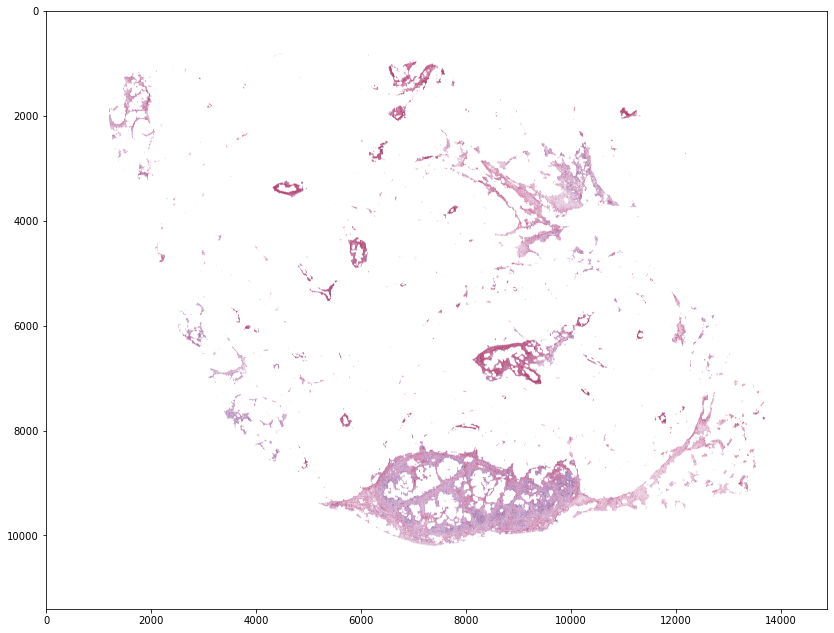

In [6]:
start=time()
plt.figure(figsize=(14,12))
plt.imshow(region)
print("plotting: {:.2f} sec elapsed".format(time()-start))

In [7]:
# RGB to Haematoxylin-Eosin-DAB (HED) color space conversion.
# Hematoxylin + Eosin + DAB
start=time()
rgb_from_hed = np.array([[0.650, 0.704, 0.286],
                         [0.072, 0.990, 0.105],
                         [0.268, 0.570, 0.776]])
hed_from_rgb = scipy.linalg.inv(rgb_from_hed)
ihc_hed = separate_stains(region, hed_from_rgb)
Hema = ihc_hed[:, :, 0]
print("color deconvolution: {:.2f} sec elapsed".format(time()-start))

color deconvolution: 6.48 sec elapsed


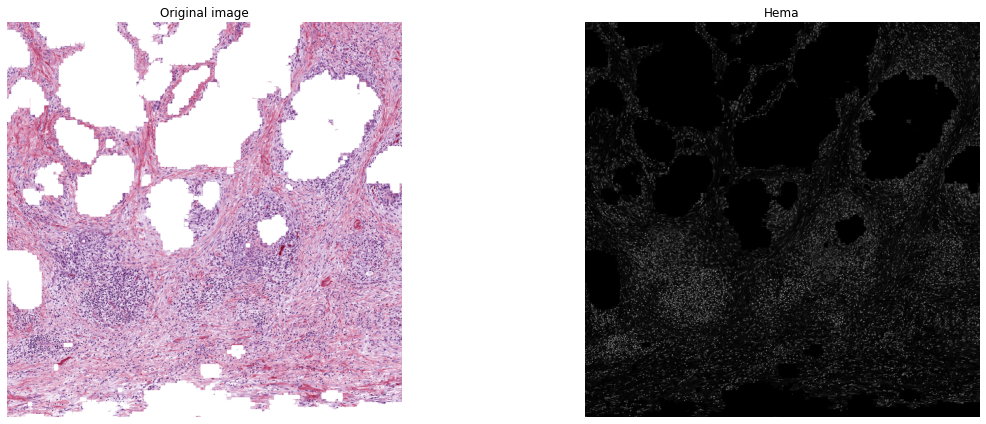

In [8]:
t,b,l,r = 9000,10000,8000,9000
# remove this for production mode #######################
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(region[t:b,l:r])
ax[0].set_title("Original image")

ax[1].imshow(Hema[t:b,l:r], cmap='gray')
ax[1].set_title("Hema")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [9]:
#1 intensity thresholding
threshold = 0.25
Hematoxylin = cv2.normalize(Hema, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
np.save(fn+'_H.npy',Hematoxylin)
# Hematoxylin = np.load(fn+'_H.npy')
# plt.imshow(Hematoxylin)
Hematoxylin[Hematoxylin<threshold]=0
Hematoxylin[Hematoxylin>threshold]=1
labeled_bw = label(Hematoxylin).astype(np.int64)

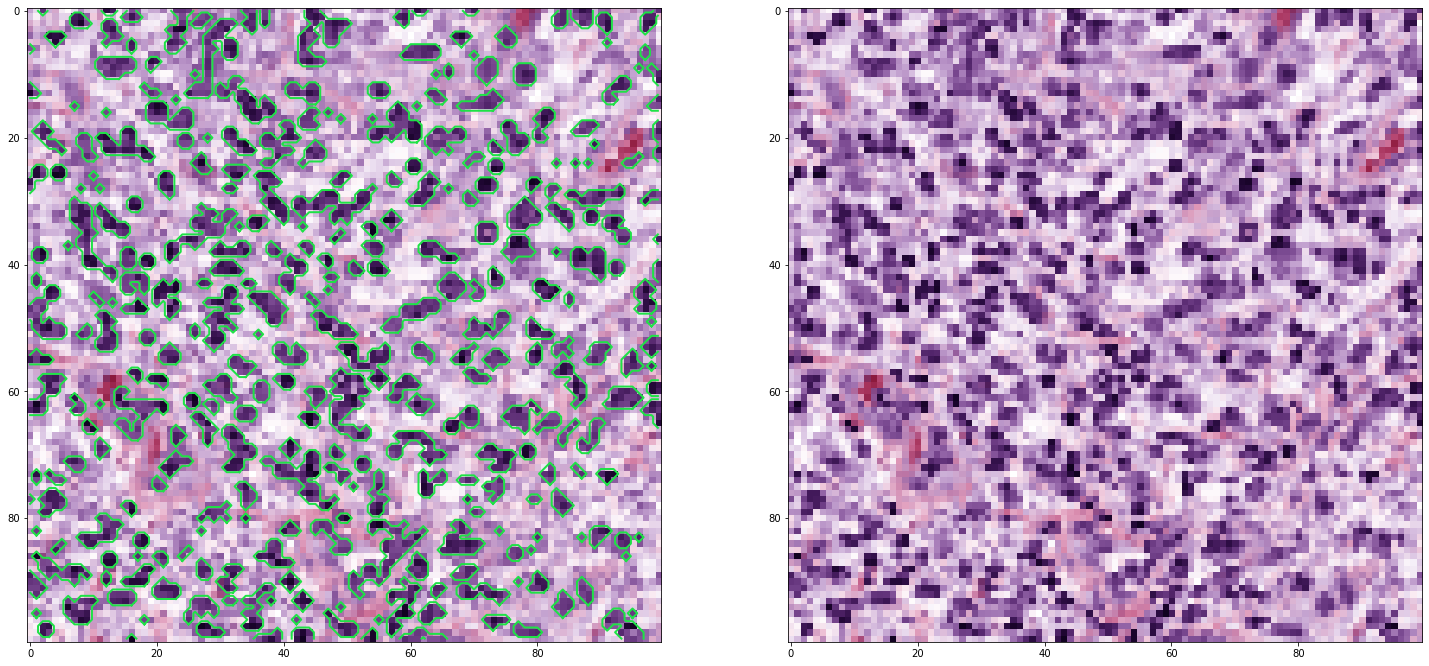

In [10]:
# plt.imshow(labeled_bw)
fig,ax=plt.subplots(1,2,figsize=(25,12))
tt=t+650
ll=l+250
bb=b-250
rr=r-650

ax[0].imshow(region.astype(np.float32)[tt:bb,ll:rr])
bw = (labeled_bw>0)*1
bw = binary_fill_holes(bw)
contours = find_contours(bw[tt:bb,ll:rr],0.25,fully_connected='high')
for n, contour in enumerate(contours):
    ax[0].plot(contour[:, 1], contour[:, 0], '#1EE246',linewidth=2)

ax[1].imshow(region.astype(np.float32)[tt:bb,ll:rr])

In [11]:
#pre-size filter
start=time()
remove_small_objects(labeled_bw,min_size=4,connectivity=1,in_place=True)
print("{:.2f} sec elapsed".format(time()-start))
labeled_bw = label((labeled_bw>0)*1).astype(np.int32)

0.59 sec elapsed


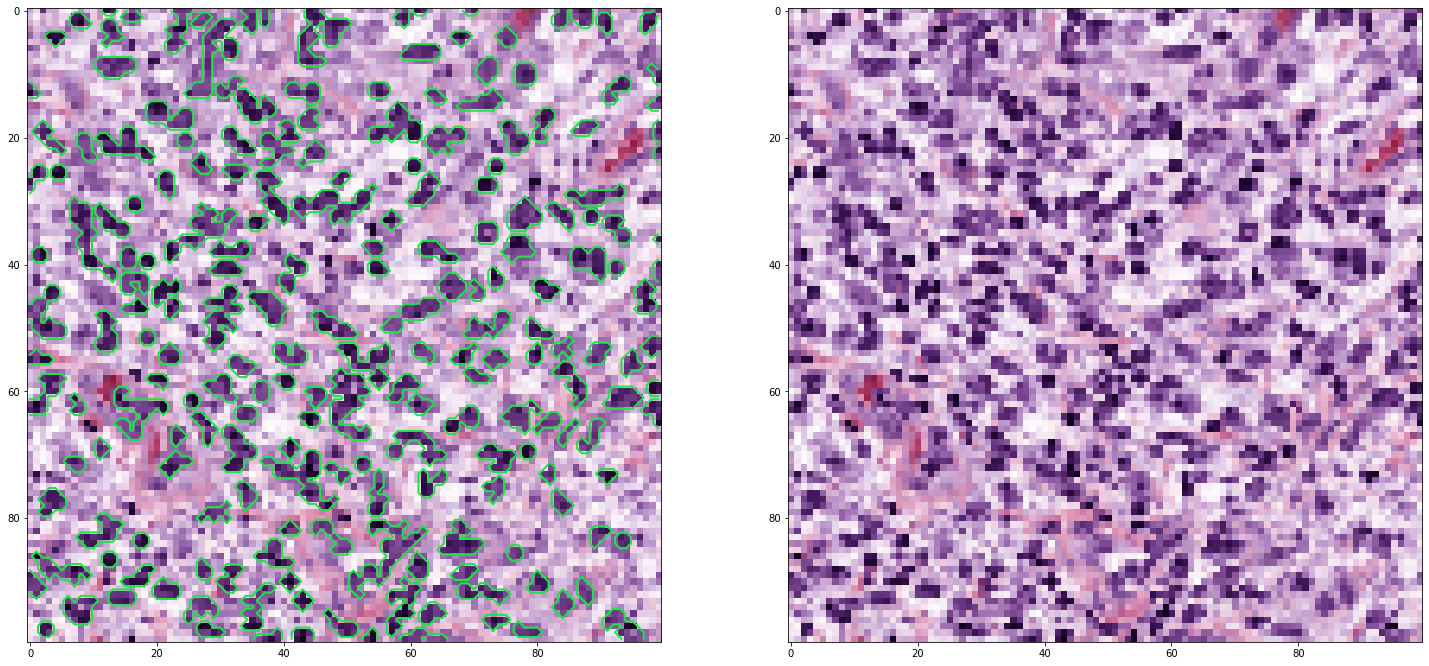

In [12]:
fig,ax=plt.subplots(1,2,figsize=(25,12))
ax[0].imshow(region.astype(np.float32)[tt:bb,ll:rr])
bw = (labeled_bw>0)*1
bw = binary_fill_holes(bw)
contours = find_contours(bw[tt:bb,ll:rr],0.25,fully_connected='high')
for n, contour in enumerate(contours):
    ax[0].plot(contour[:, 1], contour[:, 0], '#1EE246',linewidth=2)

ax[1].imshow(region.astype(np.float32)[tt:bb,ll:rr])

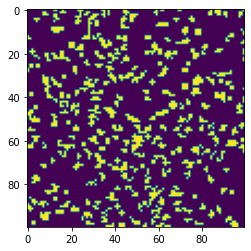

In [13]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

bww = bw[tt:bb,ll:rr]
plt.imshow(bww)

In [14]:
distance = ndi.distance_transform_edt(bww)

In [15]:
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=bww)

In [16]:
markers = ndi.label(local_maxi)[0]

In [17]:
labels = watershed(-distance, markers, mask=bww)

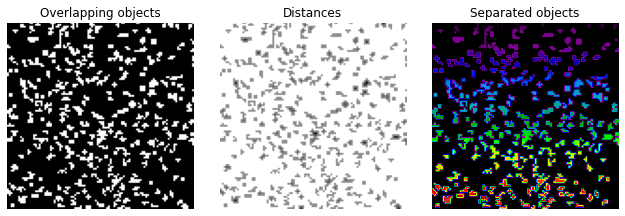

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(bww, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

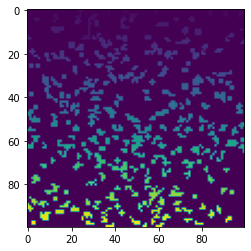

In [24]:
plt.imshow(labels)

In [25]:
remove_small_objects(labels,min_size=4,connectivity=1,in_place=True)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,  10,  10,   0],
       [  0,   0,   0, ...,  10,  10,   0],
       ...,
       [  0,   0, 368, ...,   0,   0,   0],
       [  0,   0, 368, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

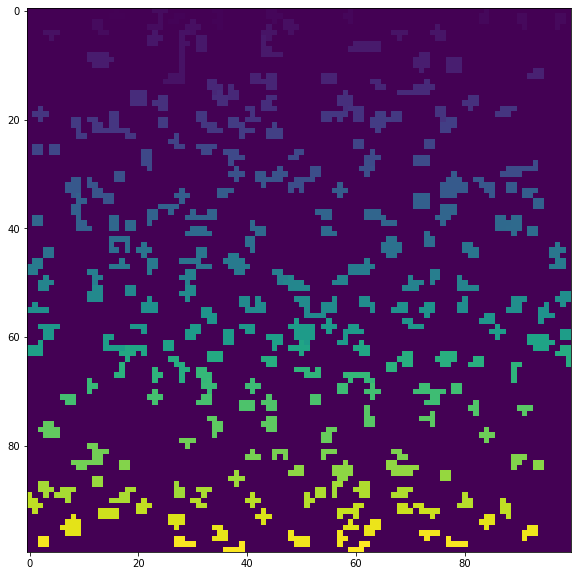

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(labels)

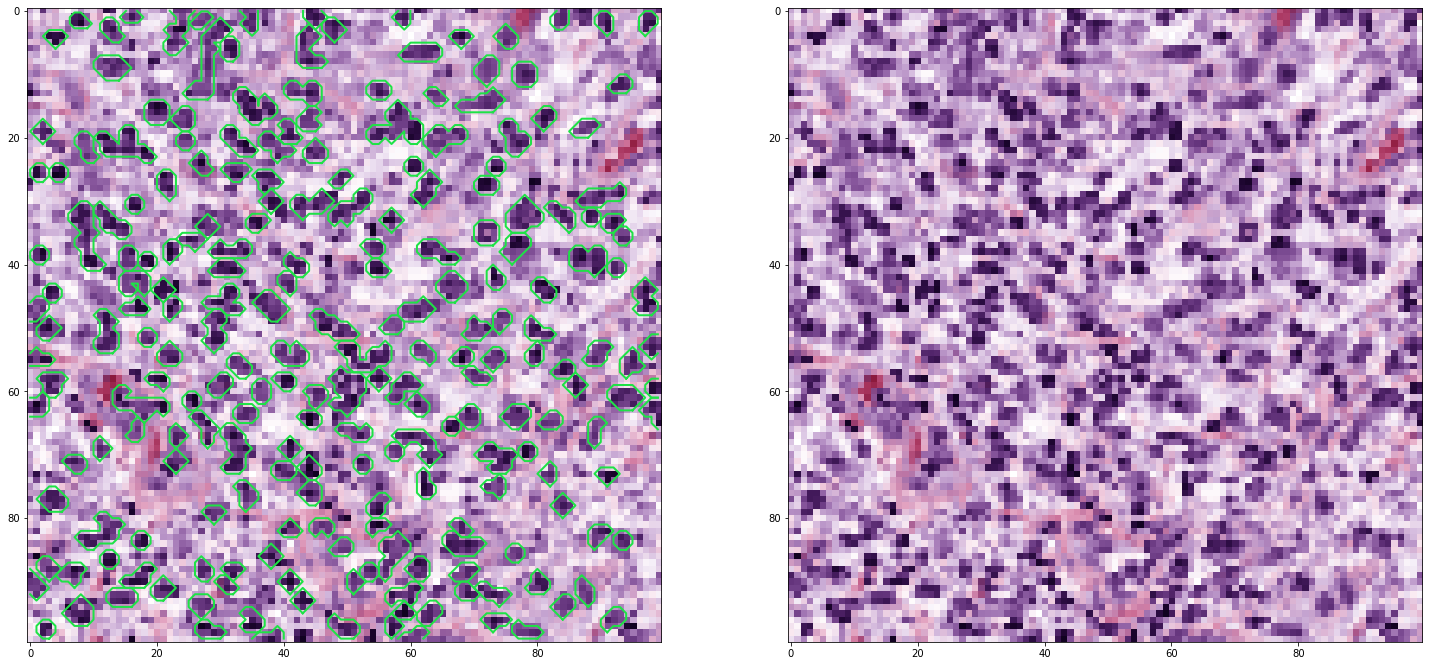

In [28]:
fig,ax=plt.subplots(1,2,figsize=(25,12))
ax[0].imshow(region.astype(np.float32)[tt:bb,ll:rr])

contours = find_contours(labels,0.25,fully_connected='low')
for n, contour in enumerate(contours):
    ax[0].plot(contour[:, 1], contour[:, 0], '#1EE246',linewidth=2)

ax[1].imshow(region.astype(np.float32)[tt:bb,ll:rr])

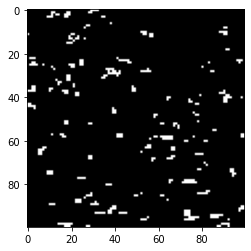

In [78]:
# # before size filter
# start=time()
# prop = regionprops(labeled_bw)
# area = [np.sum(x._label_image[x._slice] == x.label) for x in prop]
# print("{:.2f} sec elapsed".format(time()-start))
plt.imshow((labeled_bw[tt:bb,ll:rr]>0)*1,cmap='gray')

In [79]:
# before size filter
# start=time()
# prop2 = regionprops(labeled_bw)
# area2 = Parallel(n_jobs=-4, prefer="threads")(delayed(np.sum)(x._label_image[x._slice] == x.label) for x in prop2)
# print("{:.2f} sec elapsed".format(time()-start))

def regionarea(x):
    return x['area']

start=time()
prop2 = regionprops(labeled_bw[tt:bb,ll:rr])
area2 = Parallel(n_jobs=-4, prefer="threads")(delayed(regionarea)(x) for x in prop2)
print("{:.2f} sec elapsed".format(time()-start))
plt.hist(area2)

TypeError: Non-integer label_image types are ambiguous

In [ ]:
#2 size filter
start=time()
remove_small_objects(labeled_bw,min_size=50,connectivity=1,in_place=True)
print(time()-start,'sec elapsed')

In [ ]:
# before AR filter
# ARs = [_['major_axis_length']/_['minor_axis_length'] for _ in prop]
# plt.hist(ARs)
# plt.title('Aspect Ratio',fontsize=30)

start=time()
prop2 = regionprops(labeled_bw)
def regionar(x):
    return x['major_axis_length']/x['minor_axis_length']
ARs = Parallel(n_jobs=-4, prefer="threads")(delayed(regionar)(x) for x in prop2)
print("{:.2f} sec elapsed".format(time()-start))

In [ ]:
plt.hist(ARs)
plt.title('Aspect Ratio',fontsize=30)

In [ ]:
#3 AR filter
minAR = 2
maxAR = 100
for prop in regionprops(labeled_bw):
    AR = prop['major_axis_length']/prop['minor_axis_length']
    if AR<minAR: labeled_bw[labeled_bw==prop.label]=0
    if AR>maxAR: labeled_bw[labeled_bw==prop.label]=0

In [ ]:
#3 AR filter
minAR = 2
maxAR = 100
for prop in regionprops(labeled_bw):
    AR = prop['major_axis_length']/prop['minor_axis_length']
    if AR<minAR: labeled_bw[labeled_bw==prop.label]=0
    if AR>maxAR: labeled_bw[labeled_bw==prop.label]=0

In [ ]:
# after AR filter
prop = regionprops(labeled_bw)
ARs = [_['major_axis_length']/_['minor_axis_length'] for _ in prop]
plt.hist(ARs)
plt.title('Aspect Ratio',fontsize=30)

In [ ]:
# before SF filter
SFs = [4*np.pi*_['area']/_['perimeter']**2 for _ in prop]
plt.hist(SFs)
plt.title('Circularity',fontsize=30)


In [ ]:
#4 SF filter
minSF = 0.1
maxSF = 0.6
for prop in regionprops(labeled_bw):
    SF = 4*np.pi*prop['area']/prop['perimeter']**2
    if SF<minSF: labeled_bw[labeled_bw==prop.label]=0; print(prop.label)
    if SF>maxSF: labeled_bw[labeled_bw==prop.label]=0; print(prop.label)

In [ ]:
# after SF filter
prop = regionprops(labeled_bw)
SFs = [4*np.pi*_['area']/_['perimeter']**2 for _ in prop]
plt.hist(SFs)
plt.title('Circularity',fontsize=30)

In [ ]:
#distance filter
min_dist_to_neighbor = 50
Y = [_.centroid for _ in prop]
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(Y)
distances, indices = nbrs.kneighbors(Y)
close_objects = np.array(prop)[distances[:,1]<min_dist_to_neighbor]
for close_object in close_objects:
    labeled_bw[labeled_bw==close_object.label]=0
